In [209]:
%pylab inline
import re,os
n=18
max_l=6
in_root = '/mnt/store1/oliverphilcox/3PCF_QPM_v3/SE_out_ITC/qpm'
in_root2 = '/mnt/store1/oliverphilcox/3PCF_QPM_v3/SE_out_General/qpm'
rand_it = 32

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def xi_reader(in_str,root1=True):
    
    if root1:
        file_name = in_root+'.'+in_str+'.out'
    else:
        file_name = in_root2+'.'+in_str+'.out'

    dat = np.zeros([n,1])

    if not os.path.exists(file_name):
        return dat
    
    with open(file_name) as f:
        start=False
        for line in f:
            if not start:
                if re.match("# Binned",line):
                    start=True
                continue
            if len(line.split())==0:
                start=False
                continue
            if re.match('# Multipole',line):
                start=False
                continue
            x=line.split()
            b=int(x[1])
            dat[b,0]=float(x[2])
            
    return dat;
    
def check_dat(arr):
    if np.isfinite(arr.sum()):
        if np.sum(np.abs(arr))>0:
            if np.sum(np.abs(arr))<1e10:
                return True
    else:
        return False

In [3]:
rr=xi_reader('0.rrr',True)

all_xi = []
good_mocks = []

for mock_no in range(300):
    
    if not os.path.exists(in_root+'.%d.nnn_%d.out'%(mock_no,rand_it-1)):
        if not os.path.exists(in_root2+'.%d.nnn_%d.out'%(mock_no,rand_it-1)):
            continue;

    all_nn=[]
    for i in range(rand_it):
        tmp_in = xi_reader('%d.nnn_%d'%(mock_no,i))
        if not check_dat(tmp_in):
            # Check second directory
            tmp_in = xi_reader('%d.nnn_%d'%(mock_no,i),False)
        if check_dat(tmp_in):
            all_nn.append(tmp_in)
    
    if len(all_nn)!=rand_it:
        continue
        
    this_nn = np.mean(all_nn,axis=0)
    
    this_xi = this_nn/rr
    
    if check_dat(this_xi):
        all_xi.append(this_xi)
        good_mocks.append(mock_no)
    
all_xi = np.asarray(all_xi)
n_mocks1 = len(all_xi)
print("N_mocks = %d"%n_mocks1)

N_mocks = 273


In [4]:
xi_in = '/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi'
xi_r = np.genfromtxt(xi_in,max_rows=1)
xi_dat = np.genfromtxt(xi_in,skip_header=2)

In [5]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7


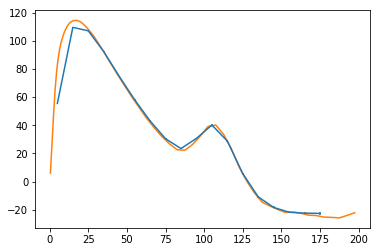

In [6]:
mean_xi = all_xi.mean(axis=0)
std_xi = all_xi.std(axis=0)
plt.errorbar(r_bins,r_bins**2*mean_xi[:,0],yerr=r_bins**2*std_xi[:,0]/np.sqrt(n_mocks1))
plt.plot(xi_r,xi_r**2*xi_dat.mean(axis=1))

In [7]:
def reader(in_str,root1=True):
    
    if root1:
        file_name = in_root+'.'+in_str+'.out'
    else:
        file_name = in_root2+'.'+in_str+'.out'
    
    dat = np.zeros([n,n,max_l+1])

    if not os.path.exists(file_name):
        return dat
    
    with open(file_name) as f:
        start=False
        for line in f:
            if not start:
                if re.match("# Multipole",line):
                    start=True
                continue
            if re.match("Multipole",line):
                continue
            if len(line.split())==0:
                start=False
                continue
            if re.match('# Saving',line):
                start=False
                continue
            x=line.split()
            b1=int(x[0])
            b2=int(x[1])
            dat[b1,b2,0]=float(x[2])/2.
            if b1!=b2:
                dat[b2,b1,0]=float(x[2])/2.
            for ell in range(1,max_l+1):
                dat[b1,b2,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
                if b1!=b2:
                    dat[b2,b1,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
    return dat;

In [8]:
rrr=reader('0.rrr',True)

all_zeta_uncorr = []
good_mocks2 = []

for mock_no in range(300):
    
    if mock_no not in good_mocks:
        continue

    all_n=[]
    for i in range(rand_it):
        tmp_in = reader('%d.nnn_%d'%(mock_no,i))
        if not check_dat(tmp_in):
            # Check second directory
            tmp_in = reader('%d.nnn_%d'%(mock_no,i),False)
        if check_dat(tmp_in):
            all_n.append(tmp_in)
    
    if len(all_n)!=rand_it:
        continue
    
    this_nnn = np.mean(all_n,axis=0)
    
    this_zeta = this_nnn/rrr[:,:,0].reshape(n,n,1)
    
    if check_dat(this_zeta):
        all_zeta_uncorr.append(this_zeta)
        good_mocks2.append(mock_no)
    
all_zeta_uncorr = np.asarray(all_zeta_uncorr)
n_mocks1 = len(all_zeta_uncorr)
print("N_mocks = %d"%n_mocks1)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


N_mocks = 245


In [9]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

f = rrr

from sympy.physics.wigner import wigner_3j

def Mjl_calc(j,ell,flist):
    s=0
    for ellprime in np.arange(1,len(flist)):
        s+=wigner_3j(ell,ellprime,j,0,0,0)**2*flist[ellprime]
    s*=(2*j+1)
    return s    

f[:,:,:]/=f[:,:,0].reshape((n,n,1))

all_Mjl=[]
for b1 in range(len(r_bins)):
    for b2 in range(len(r_bins)):
            
        Mjl = np.zeros((max_l+1,max_l+1))
        for j in range(max_l+1):
            for k in range(max_l+1):
                Mjl[j][k]=Mjl_calc(j,k,f[b1,b2,:])
        all_Mjl.append(Mjl)

In [10]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

all_zeta = []

for mock_no in range(n_mocks1):
    
    this_zeta = np.zeros([n,n,max_l+1])
    
    print('Window-correcting mock %d of %d'%(mock_no+1,n_mocks1))
    
    ind=0
    for b1 in range(len(r_bins)):
        for b2 in range(len(r_bins)):
            
            Mjl=all_Mjl[ind]
            ind+=1
            
            geometry = np.linalg.inv(np.identity(max_l+1)+Mjl)
            
            this_zeta[b1,b2,:] = geometry.dot(all_zeta_uncorr[mock_no,b1,b2,:])

    all_zeta.append(this_zeta)

Window-correcting mock 1 of 245
Window-correcting mock 2 of 245
Window-correcting mock 3 of 245
Window-correcting mock 4 of 245
Window-correcting mock 5 of 245
Window-correcting mock 6 of 245
Window-correcting mock 7 of 245
Window-correcting mock 8 of 245
Window-correcting mock 9 of 245
Window-correcting mock 10 of 245
Window-correcting mock 11 of 245
Window-correcting mock 12 of 245
Window-correcting mock 13 of 245
Window-correcting mock 14 of 245
Window-correcting mock 15 of 245
Window-correcting mock 16 of 245
Window-correcting mock 17 of 245
Window-correcting mock 18 of 245
Window-correcting mock 19 of 245
Window-correcting mock 20 of 245
Window-correcting mock 21 of 245
Window-correcting mock 22 of 245
Window-correcting mock 23 of 245
Window-correcting mock 24 of 245
Window-correcting mock 25 of 245
Window-correcting mock 26 of 245
Window-correcting mock 27 of 245
Window-correcting mock 28 of 245
Window-correcting mock 29 of 245
Window-correcting mock 30 of 245
Window-correcting m

In [11]:
all_zeta = np.asarray(all_zeta)
n_mocks = len(all_zeta)

## Check Q ratio

#### Get Q approximation

In [12]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(xi_r,xi_r**2*xi_dat.mean(axis=1),s=1)

xi_fun = lambda r: spl(r)/r**2


In [13]:
from scipy.special import legendre

mu_arr = np.arange(-1.,1.,0.05)

all_Q = np.zeros([n,n,len(mu_arr)])

for b1 in range(n):
    for b2 in range(n):
        if b1==b2:
            continue
        r1 = r_bins[b1]
        r2 = r_bins[b2]

        this_zeta = all_zeta.mean(axis=0)[b1,b2]

        r3_arr = np.sqrt(r2**2+r1**2-2*r1*r2*mu_arr)

        xi_12 = xi_fun(r1)*xi_fun(r2)*np.ones_like(r3_arr)

        ells = np.arange(max_l+1)

        this_zeta_mu = np.zeros(len(mu_arr))

        for ell in ells:
            this_zeta_mu+=legendre(ell)(mu_arr)*this_zeta[ell]

        this_Q = this_zeta_mu/(xi_12+xi_fun(r1)*xi_fun(r3_arr)+xi_fun(r2)*xi_fun(r3_arr))
        
        all_Q[b1,b2]=this_Q

## Compress Q ratio

In [14]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

Q_compress = np.zeros([n-min_r_bin,len(mu_arr)])

denom = np.zeros([n-min_r_bin])

for b1 in range(min_r_bin,n):
    for b2 in range(3,b1-3):
        Q_compress[b1-min_r_bin,:]+=all_Q[b1,b2,:]*vol_r[b2]
        denom[b1-min_r_bin]+=vol_r[b2]
    Q_compress[b1-min_r_bin,:]/=denom[b1-min_r_bin]

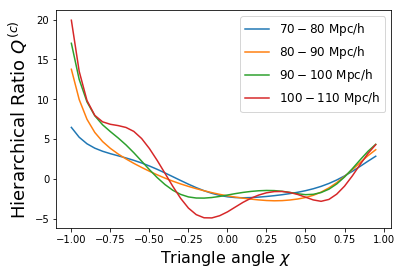

In [259]:
for i in range(len(Q_compress)-7):
    plt.plot(mu_arr,Q_compress[i],label=r'$%d-%d$ Mpc/h'%(r_min[min_r_bin+i],r_min[min_r_bin+i+1]))
plt.legend(fontsize=12)
#plt.ylim([-20,60])
plt.ylabel(r'Hierarchical Ratio $Q^{(c)}$',fontsize=18);plt.xlabel(r' Triangle angle $\chi$',fontsize=16);

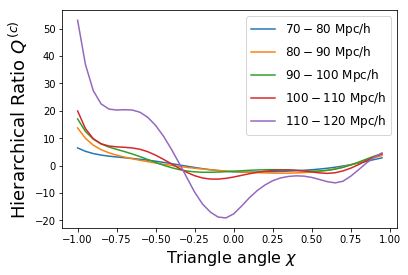

In [16]:
for i in range(len(Q_compress)-6):
    plt.plot(mu_arr,Q_compress[i],label=r'$%d-%d$ Mpc/h'%(r_min[min_r_bin+i],r_min[min_r_bin+i+1]))
plt.legend(fontsize=12)
#plt.ylim([-20,60])
plt.ylabel(r'Hierarchical Ratio $Q^{(c)}$',fontsize=18);plt.xlabel(r' Triangle angle $\chi$',fontsize=16);

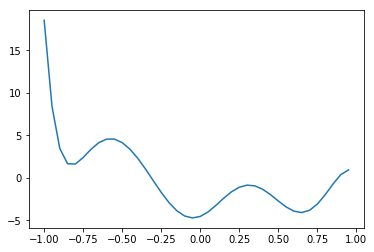

In [17]:
plt.plot(mu_arr,all_Q[6,5])

#### Compress 3PCF

In [18]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

zeta_compress = np.zeros([n_mocks1,n-min_r_bin,max_l+1])

for i in range(n_mocks):
    denom = np.zeros([n-min_r_bin])

    for b1 in range(min_r_bin,n):
        for b2 in range(3,b1-3):
            zeta_compress[i,b1-min_r_bin,:]+=all_zeta[i,b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        zeta_compress[i,b1-min_r_bin,:]/=denom[b1-min_r_bin]

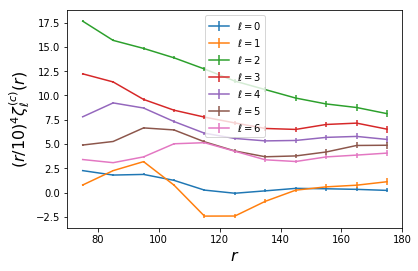

In [19]:
for ell in range(max_l+1):
    plt.errorbar(r_bins[min_r_bin:],(r_bins[min_r_bin:]/10)**4*zeta_compress.mean(axis=0)[:,ell],
                 (r_bins[min_r_bin:]/10.)**4*zeta_compress.std(axis=0)[:,ell]/np.sqrt(n_mocks),label=r'$\ell=%d$'%ell)
plt.legend();
plt.ylabel(r'$(r/10)^4\zeta^{(c)}_\ell(r)$',fontsize=16);
plt.xlabel(r'$r$',fontsize=16);

In [20]:
np.savez('plot_data/3PCF_compressed_plot.npz',max_l=max_l,r_bins=r_bins,
        min_r_bin=min_r_bin,zeta_compress=zeta_compress,n_mocks=n_mocks,)

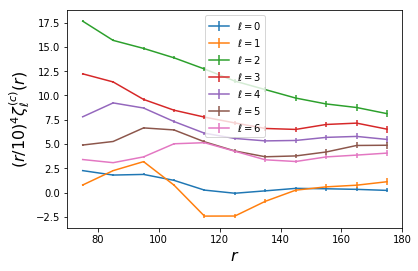

In [21]:
for ell in range(max_l+1):
    plt.errorbar(r_bins[min_r_bin:],(r_bins[min_r_bin:]/10)**4*zeta_compress.mean(axis=0)[:,ell],
                 (r_bins[min_r_bin:]/10.)**4*zeta_compress.std(axis=0)[:,ell]/np.sqrt(n_mocks),label=r'$\ell=%d$'%ell)
plt.legend();
plt.ylabel(r'$(r/10)^4\zeta^{(c)}_\ell(r)$',fontsize=16);
plt.xlabel(r'$r$',fontsize=16);

In [22]:
all_N_gal = np.load('/mnt/store1/oliverphilcox/3PCF_QPM_v3/all_N_gal.npy')
these_N_gal = all_N_gal[good_mocks2]

In [151]:
zeta_compress_flat=[]
for i in range(n_mocks):
    zeta_compress_flat.append(zeta_compress[i].T.ravel())
zeta_compress_flat=np.asarray(zeta_compress_flat)

cov_zeta = np.cov(zeta_compress_flat.T)#,aweights=these_N_gal/np.mean(these_N_gal))

In [152]:
def plotter(mat,vmax=np.inf,perc=99,rmax=0):
    if vmax==np.inf:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    if rmax==0:
        rmax = len(mat)
    plt.ylim([-0.5,rmax-0.5])
    plt.xlim([-0.5,rmax-0.5])

## Load theory:

In [348]:
theory = np.load('/mnt/store1/oliverphilcox/3PCF_QPM_v3/combined_compressed_qpm_theory.npz')
c3=theory['c3']
c4=theory['c4']
c5=theory['c5']
c6=theory['c6']-theory['c60']
c_theory = c3+c4+c5+c6

In [261]:
max_l = 6
n_mat = len(r_bins[min_r_bin:])
sample_cov = cov_zeta[:(max_l+1)*n_mat,:(max_l+1)*n_mat]
theory_cov = c_theory[:(max_l+1)*n_mat,:(max_l+1)*n_mat]

In [262]:
r_all = np.concatenate([r_bins[min_r_bin:] for _ in range(max_l+1)])
r_mat = np.matmul((r_all**2).reshape(-1,1),(r_all**2).reshape(1,-1))

In [320]:
from scipy.optimize import minimize

def cov_model(alpha):
    return (c3*alpha**3+c4*alpha**2+c5*alpha+c6)[:(max_l+1)*n_mat,:(max_l+1)*n_mat]


def KL_div_lin(alpha):
    c_th = cov_model(alpha)*1.05
    prec = np.linalg.inv(c_th)
    slog1 = np.linalg.slogdet(prec)
    if slog1[0]<0:
        return np.inf
    slog2 = np.linalg.slogdet(sample_cov)
    if slog2[0]<0:
        return np.inf
    return 0.5*(np.trace(np.matmul(sample_cov,prec))-slog1[1]-slog2[1]-len(sample_cov))

start_x = 1.1
x=minimize(KL_div_lin,start_x)

if x.success and x.x!=start_x:
    print("Success with alpha = %.4f, KL = %.2f"%(x.x,KL_div_lin(x.x)))
    c_opt = cov_model(x.x)
else:
    print("Could not fit - using alpha = 1.5")
    c_opt = cov_model(1.8)#*2

Success with alpha = 1.2026, KL = 7.68


In [321]:
def KL_div_2d(par):
    alpha,rescale=par
    if alpha<1:
        return np.inf
    c_th = rescale*cov_model(alpha)
    prec = np.linalg.inv(c_th)
    slog1 = np.linalg.slogdet(prec)
    if slog1[0]<0:
        return np.inf
    slog2 = np.linalg.slogdet(sample_cov)
    if slog2[0]<0:
        return np.inf
    return 0.5*(np.trace(np.matmul(sample_cov,prec))-slog1[1]-slog2[1]-len(sample_cov))


start_x = [1.,0.9]
x=minimize(KL_div_2d,start_x)

if x.success and x.x[0]!=start_x[0]:
    print("Success with alpha = %.4f, rescale = %.4f, KL = %.2f"%(x.x[0],x.x[1],KL_div_2d(x.x)))
    #c_opt = cov_model(x.x[0])*x.x[1]
else:
    print("Could not fit - using alpha = 1.5")
    #c_opt = cov_model(1.2515)#*2

Could not fit - using alpha = 1.5


In [322]:
n_bins*(n_bins+1)/(4.*KL_div_lin(1.26))

194.1681570701146

In [323]:
n_bins = len(c_opt)
exp_KL = n_bins*(n_bins+1)/4.*(1./theory['n_eff']+1./n_mocks)
print("Expected KL divergence: %.2f"%exp_KL)

Expected KL divergence: 6.21


In [324]:
exp_KL

6.205220749776844

In [325]:
b3=np.loadtxt('/mnt/store1/oliverphilcox/3PCF_QPM_v3/BinCorrectionFactor_n15_11.txt')
b1=np.loadtxt('/mnt/store1/oliverphilcox/3PCF/CorrectedBinCorrectionFactor_n15_11.txt')

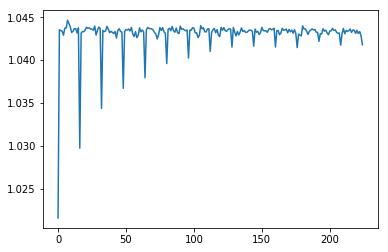

In [326]:
plt.plot((b3/b1)[:,0])
#plt.ylim([0,2])

## NB: We can probably lower alpha by ~10% by changing the galaxy normalization to mean $N_\mathrm{gal}$ not first galaxy

## Add a global renormalization

## Check KL divergence with $N_\mathrm{gal}$ weighting

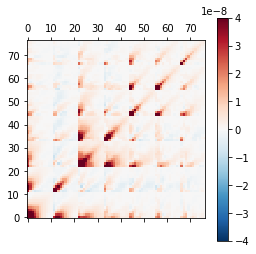

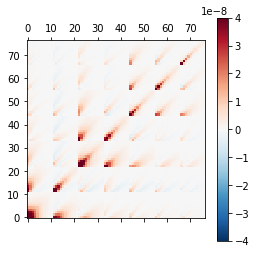

In [327]:
plotter(sample_cov,vmax=4e-8)
plotter(c_opt,vmax=4e-8)

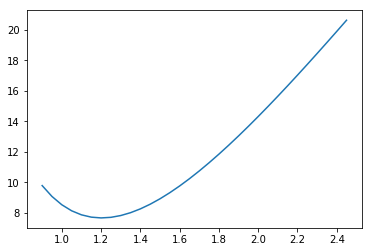

In [328]:
alphas = np.arange(0.9,2.5,0.05)
divs = [KL_div_lin(al) for al in alphas]
plt.plot(alphas,divs)

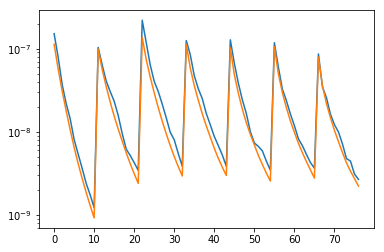

In [329]:
plt.plot(np.diag(sample_cov));
plt.plot(np.diag(c_opt))
plt.yscale('log');

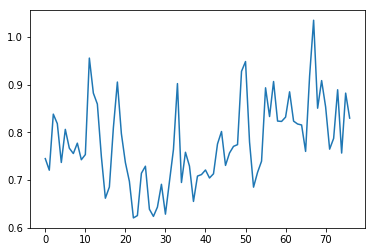

In [330]:
plt.plot(np.diag(c_opt/sample_cov))

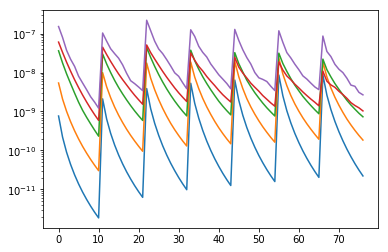

In [331]:
plt.plot(np.diag(c3))
plt.plot(np.diag(c4))
plt.plot(np.diag(c5))
plt.plot(np.diag(c6))
plt.plot(np.diag(sample_cov))
plt.yscale('log')

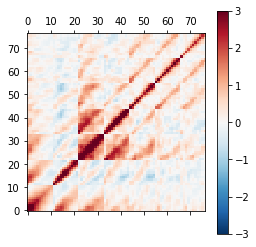

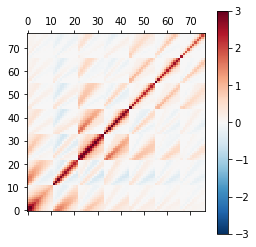

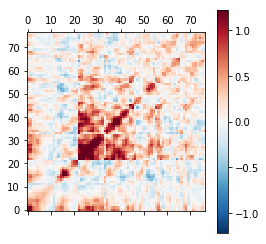

In [332]:
plotter(sample_cov*r_mat,vmax=3)
plotter(c_opt*r_mat,vmax=3)
plotter((sample_cov-c_opt)*r_mat)

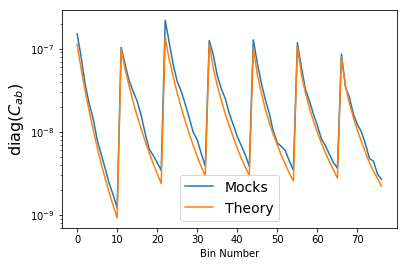

In [333]:
plt.plot(np.diag(sample_cov),label=r'Mocks')
plt.plot(np.diag(c_opt),label=r'Theory')
plt.yscale('log')
plt.legend(fontsize=14);
plt.xlabel(r'Bin Number')
plt.ylabel(r'$\mathrm{diag}(C_{ab})$',fontsize=16);

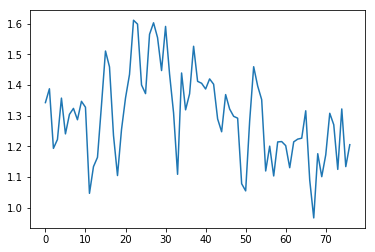

In [334]:
plt.plot(np.diag(sample_cov/c_opt))

In [335]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

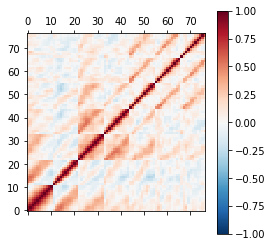

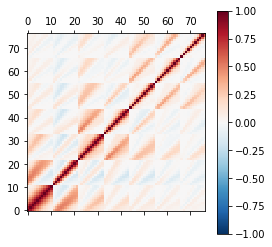

In [336]:
plotter(reduce(sample_cov))
plotter(reduce(c_opt))

In [350]:
theory_D=theory.f.D_matrix

In [370]:
D_mat = (len(sample_cov)+1.)/(n_mocks-1.)
prec_theory=np.matmul((np.eye(len(theory_D))-theory_D),np.linalg.inv(c_opt))
prec_obs = np.linalg.inv(sample_cov)*(1.-D_mat)

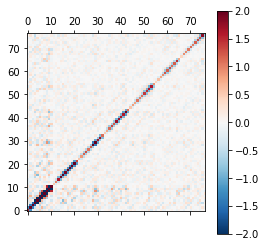

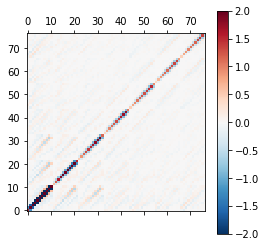

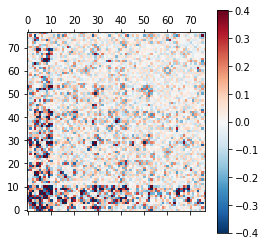

In [371]:
plotter(prec_obs/r_mat,vmax=2)
plotter(prec_theory/r_mat,vmax=2)
plotter((prec_obs-prec_theory)/r_mat)

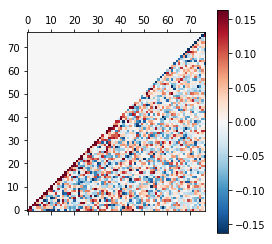

In [372]:
chol = np.linalg.cholesky(sample_cov)
disc = np.matmul(chol.T,np.matmul(prec_theory,chol))-np.eye(len(prec_theory))
plotter(np.triu(disc))

In [375]:
np.savez('plot_data/cov_matrices.npz',sample_cov=sample_cov,c_opt=c_opt,r_mat=r_mat,prec_obs=prec_obs,
        prec_theory=prec_theory,disc=disc)

In [374]:
mean_disc=np.mean(np.tril(disc))*100
rms_disc = np.std(np.tril(disc))*100
DoF = len(cov_zeta)
print("mean: %.2f rms: %.2f"%(mean_disc,rms_disc))
print("Expected RMS: %.2f"%(DoF/np.sqrt(n_mocks)))

mean: 0.13 rms: 5.83
Expected RMS: 4.92
